# Lotka Volterra Optimisation

This tutorial will cover the use of black-box optimisation on Lotka Volterra, composed of ordinary differential equations.

Black-box optimisation applied to Lotka Volterra means searching for parameter values, like birth and predation rates that make the model outputs best match observed population data, without needing access to or derivatives of the internal equations. 

The optimiser only "sees" the model's inputs and outputs, evaluating how well each trial run fits experimental or target outcomes. This approach is especially useful when the biological processes are too complex, nonlinear, or computationally expensive to model analytically, allowing calibration of Lotka Volterra purely through iterative evaluation and intelligent search.

# Imports

We will first import all required dependencies.

In [1]:
import pandas as pd
import numpy as np
from calisim.example_models import LotkaVolterraModel
import os.path as osp

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.optimisation import OptimisationMethod, OptimisationMethodModel
from calisim.statistics import MeanSquaredError, MeanPinballLoss

[WARNING 10-27 20:32:27] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


# Observed data

We will next load the observed field data.

In [3]:
model = LotkaVolterraModel()
observed_data = model.get_observed_data()
observed_data

,year,lynx,hare
0,1900.0,4.0,30.0
1,1901.0,6.1,47.2
2,1902.0,9.8,70.2
3,1903.0,35.2,77.4
4,1904.0,59.4,36.3
5,1905.0,41.7,20.6
6,1906.0,19.0,18.1
7,1907.0,13.0,21.4
8,1908.0,8.3,22.0
9,1909.0,9.1,25.4


# Calibration procedure

## Single-objective optimisation

We will next run the calibration procedures against Lynx population data. In this case, we will perform black-box optimisation.

We begin by specifying our parameter distributions. We will calibrate 2 parameters:

- α (alpha): Prey birth rate: how fast the hares multiply when there's no danger.
- β (beta): Predation rate: how often lynxes successfully consume prey.

In [18]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="alpha",
			distribution_name="uniform",
			distribution_args=[0.4, 0.55],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="beta",
			distribution_name="uniform",
			distribution_args=[0.02, 0.03],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

We'll define an objective function for our optimiser, which will return the discrepancy between observed and simulated population rates as determined by the mean squared error (MSE) metric. We'll aim to maximise the predictive accuracy of Lotka Volterra by minimising the MSE returned by our objective function. This is a single objective optimisation problem.

In [19]:
def objective(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None, t: pd.Series
) -> float | list[float]:
    model = LotkaVolterraModel()
    simulation_parameters = dict(h0=34.0, l0=5.9, t=t, gamma=0.84, delta=0.026)
    
    for k in ["alpha", "beta"]:
        simulation_parameters[k] = parameters[k]
        
    simulated_data = model.simulate(simulation_parameters).lynx.values
    metric = MeanSquaredError()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

We'll next run our black-box optimisation procedure using the [Tree-Structured Parsen Estimator (TPES) from the Optuna library](https://optuna.org/).

**TPES** is a Bayesian optimisation method that uses two density-estimation surrogate models to learn the distribution of parameters from Lotka Volterra that lead to **good** and **bad** results where:

- $l(x) = p(x \mid y < y^*) $: models parameter values that produced *good* results  
- $g(x) = p(x \mid y \ge y^*) $: models parameter values that produced *bad* results

Here $x$ are our parameter sets and $y^*$ is a performance threshold (often a quantile of observed losses). New candidate parameter sets are chosen to maximise the ratio **l(x) / g(x)**. In other words, we want to evaluate solutions that look like past winners but are still uncertain. TPES is efficient for high-dimensional and mixed-type search spaces.

[More information on TPES can be found using this link](https://arxiv.org/abs/2304.11127).

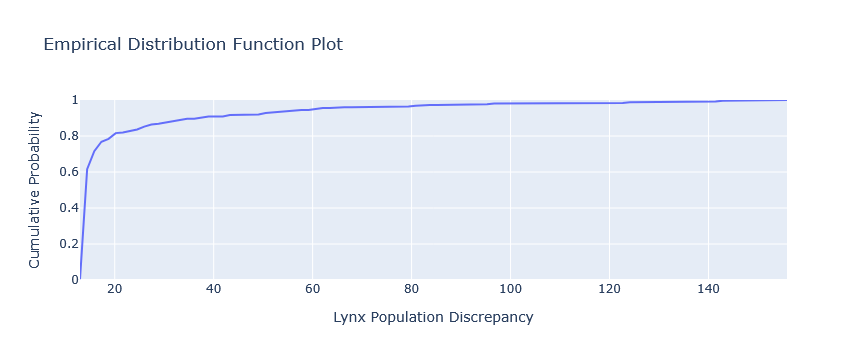

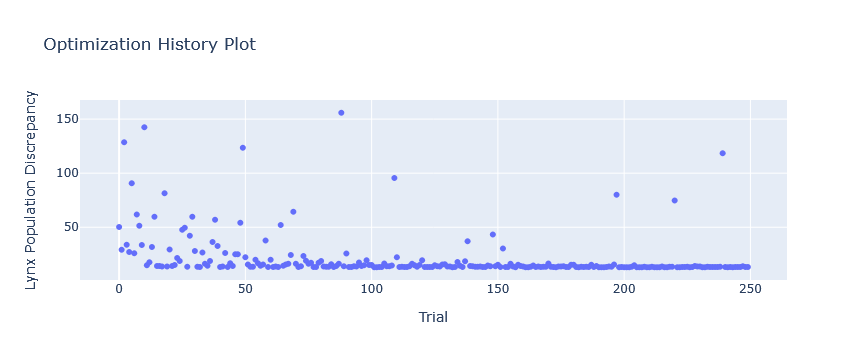

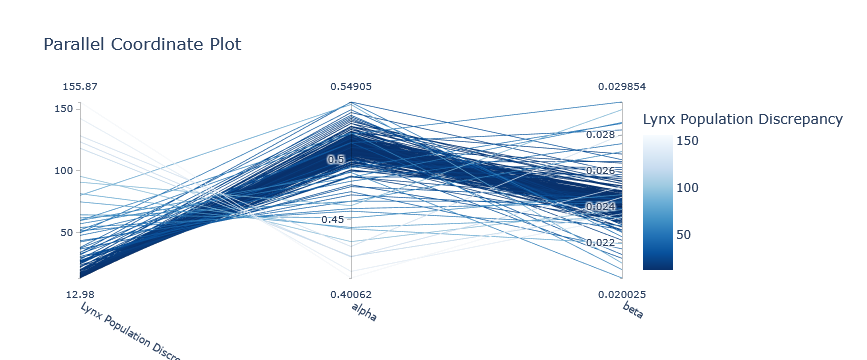

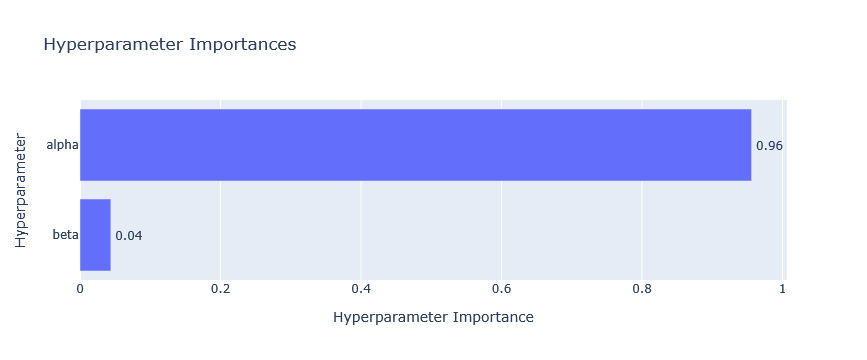

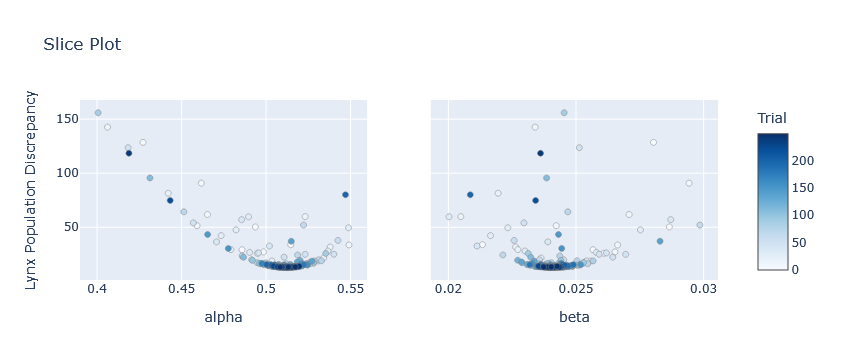

In [20]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

specification = OptimisationMethodModel(
    experiment_name="optuna_optimisation",
    parameter_spec=parameter_spec,
    observed_data=observed_data.lynx.values,
    method="tpes",
	output_labels=["Lynx Population Discrepancy"],
    directions=[
        "minimize"
    ],
    n_jobs=1,
    n_iterations=250,
    method_kwargs=dict(n_startup_trials=10),
    calibration_func_kwargs=dict(t=observed_data.year),
)

calibrator = OptimisationMethod(
    calibration_func=objective, specification=specification, engine="optuna"
)

calibrator.specify().execute().analyze()

The empirical distribution function plot depicts the proportion of trials containing our objective value. Roughly 80% of trials have an MSE below 20.

We see diminishing results in MSE beyond trial 50. So that is when optimiser begins to converge.

The parallel coordinate plot shows us the relationship between our objective values against our 2 parameters using horizontal curves. Darker curves indicate better performance. For our parallel coordinate plot, we see less spread in the trajectories of the horizontal curves at alpha. And greater spread for beta.

According to the fANOVA sensitivity analysis, alpha is the most important parameter. This is consistent with the results of the Sobol sensitivity analysis.

Our slice plots show the sampling history of TPES over trials. It quickly converges to a solution.

We'll extract the point estimates from our calibrator.

In [21]:
optimisation_df = pd.DataFrame({
    "parameter_name": [ 
        model.name
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ]
})
optimisation_df

,parameter_name,parameter_estimate
0,alpha,0.511600
1,beta,0.024028


We see the parameter estimates above for our 2 parameters. We can run Lotka Volterra again using these optimised estimates, and compare the simulated and observed Lynx population values.

<Axes: xlabel='observed', ylabel='simulated'>

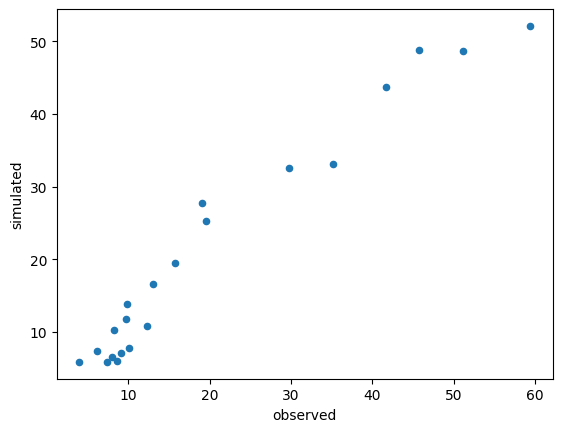

In [22]:
parameters = { 
    row["parameter_name"]: row["parameter_estimate"]
    for row in optimisation_df.to_dict("records")
}

optimised_parameters = dict(h0=34.0, l0=5.9, t=observed_data.year, gamma=0.84, delta=0.026)
for k in parameters:
    optimised_parameters[k] = parameters[k]
    
pd.DataFrame({
    "observed": observed_data.lynx.values,
    "simulated": model.simulate(optimised_parameters).lynx.values
}).plot.scatter("observed", "simulated")

After calibration via black-box optimisation, the predictive accuracy of Lotka Volterra is quite high, though there appears to be underestimation of larger values.

## Multi-objective optimisation

Let's repeat this process. But this time, we will incorporate a second objective for optimisation. Hence, we are performing multi-objective optimisation rather than single-objective optimisation. [For more information, click this link](https://www.sciencedirect.com/science/article/abs/pii/S0951832005002012).

Let's aim to minimise the discrepancy between both simulated and observed hare and lynx populations. We will use the mean pinball and MSE loss metrics respectively.

We can re-use our parameter specification from single-objective optimisation, but we'll need to define a new objective function.

In [24]:
def objective(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None, t: pd.Series
) -> float | list[float]:
    model = LotkaVolterraModel()
    simulation_parameters = dict(h0=34.0, l0=5.9, t=t, gamma=0.84, delta=0.026)
    
    for k in ["alpha", "beta"]:
        simulation_parameters[k] = parameters[k]

    results = model.simulate(simulation_parameters)
    simulated_lynx = results.lynx.values
    observed_lynx = observed_data.lynx.values
    simulated_hare = results.hare.values
    observed_hare = observed_data.hare.values 
    
    lynx_metric = MeanSquaredError()
    hare_metric = MeanPinballLoss()
    lynx_discrepancy = lynx_metric.calculate(observed_lynx, simulated_lynx)
    hare_discrepancy = hare_metric.calculate(observed_hare, simulated_hare)
    
    return lynx_discrepancy, hare_discrepancy

Let's run the multi-objective optimisation procedure, again using the TPES algorithm from the Optuna library.

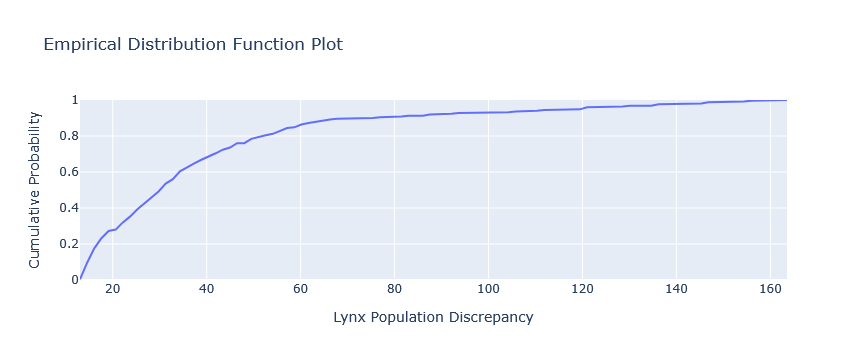

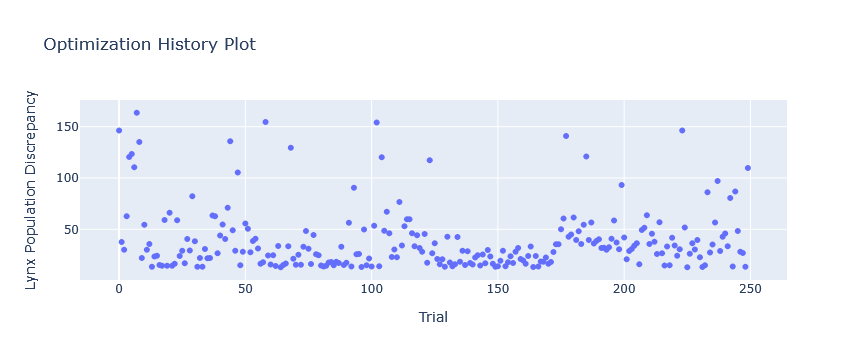

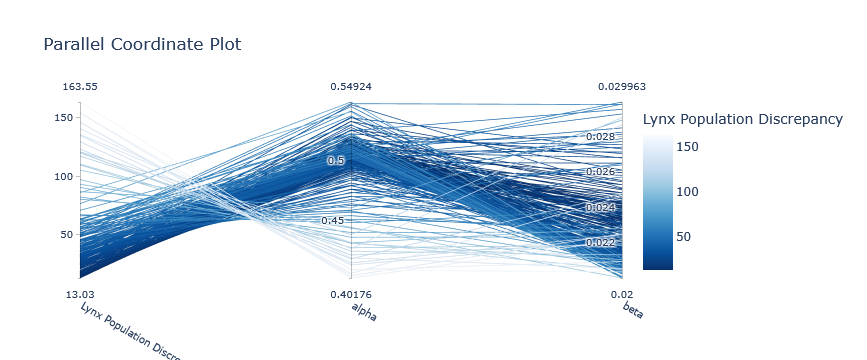

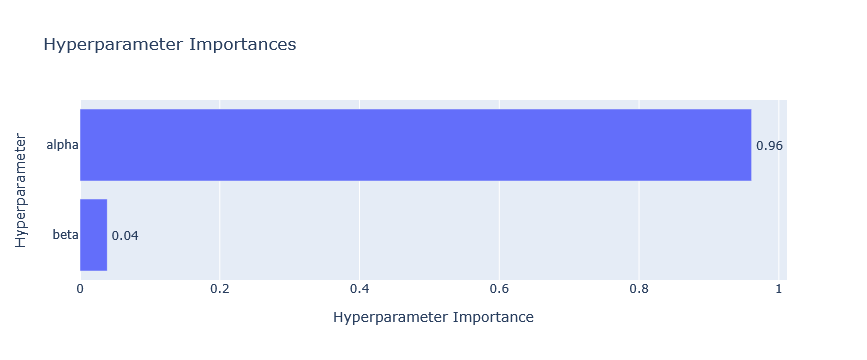

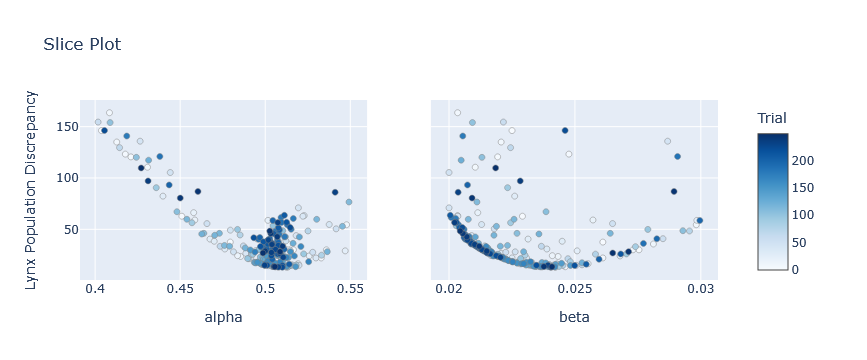

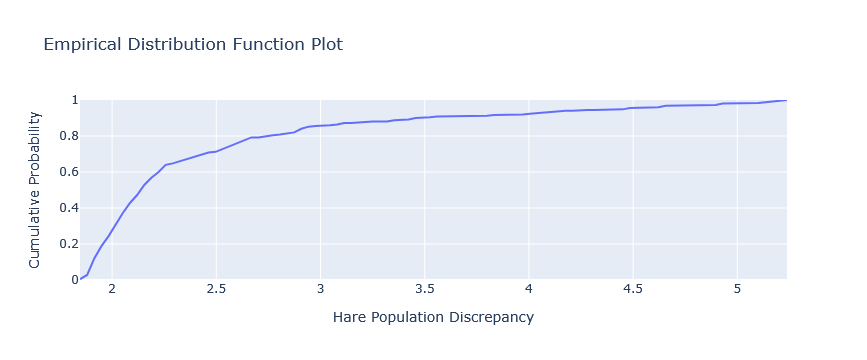

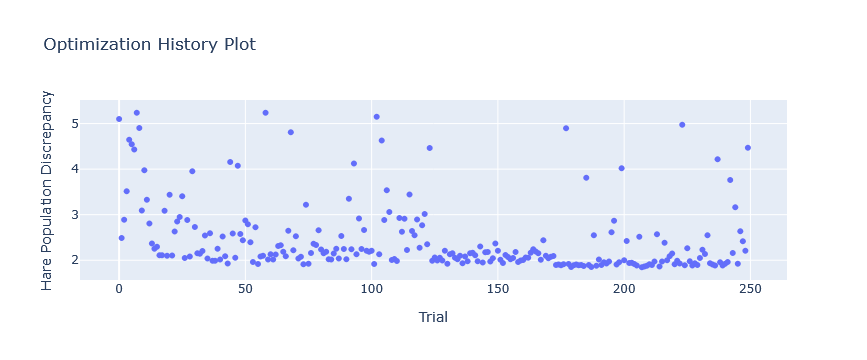

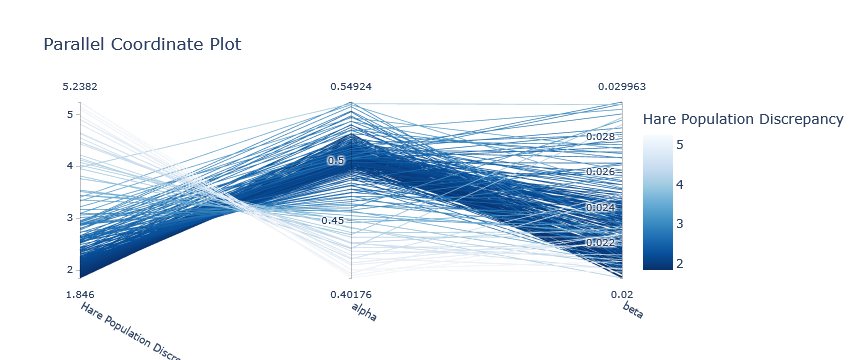

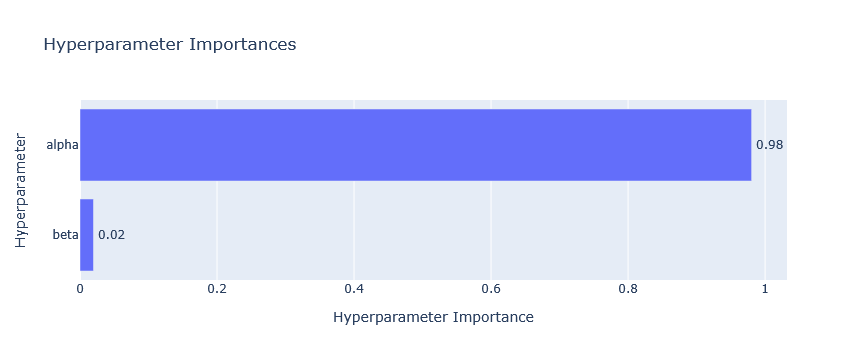

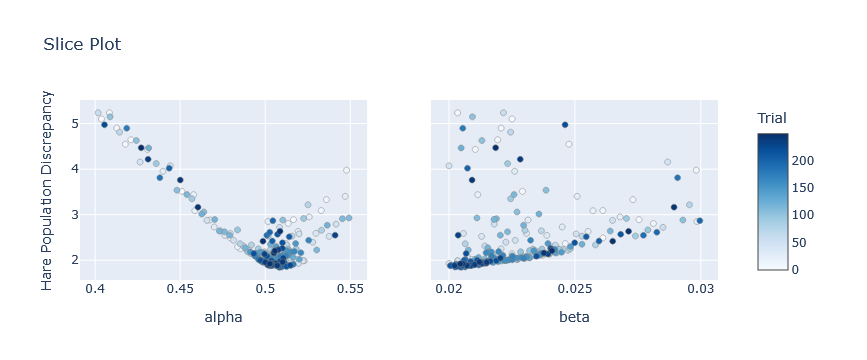

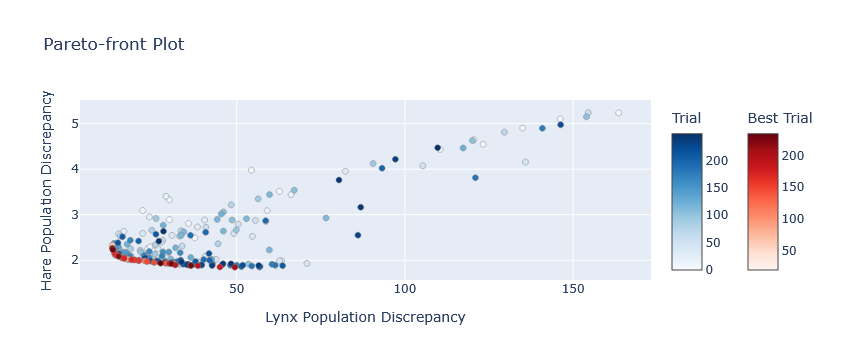

In [25]:
specification = OptimisationMethodModel(
    experiment_name="optuna_optimisation",
    parameter_spec=parameter_spec,
    observed_data=observed_data,
    method="tpes",
	output_labels=["Lynx Population Discrepancy", "Hare Population Discrepancy"],
    directions=[
        "minimize", "minimize"
    ],
    n_jobs=1,
    n_iterations=250,
    method_kwargs=dict(n_startup_trials=10),
    calibration_func_kwargs=dict(t=observed_data.year),
)


calibrator = OptimisationMethod(
    calibration_func=objective, specification=specification, engine="optuna"
)

calibrator.specify().execute().analyze()

We can see some useful visualisations for both our objectives. But we'll focus on the Pareto-front plot.

For single-objective optimisation, you will end up with a single best solution with a single optimal parameter set. The aim of multi-objective optimisation is to identify the Pareto optimal set between your different objectives. Formally, a solution is Pareto optimal if no other solution can improve one objective without worsening at least one other objective. Informally, we want every objective to "win", and no objective to "lose".

In the Pareto-front plot, we see the trade-off between the lynx population discrepancy and hare population discrepancy objectives. We could then select one parameter set from our Pareto optimal set depending on whether we wish to favour the lynx population discrepancy or hare population discrepancy. 